# VicRoads Crash Data - Random Forest and Boosting

---

This tutorial explores the fitting of Random Forest and boosting models  the VicRoads Crash Data.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/OpenActTextDev/ActuarialRegression/blob/main/Notebooks/VicRoadCrashRFBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>



## 1. Load required packages
This section loads all the necessary packages for ensemble modelling and model interpretability in R.

In [ ]:
install.packages("xgboost")
library(xgboost)          # for boosting models
library(tidyverse)        # for data manipulation and plotting
install.packages("pROC")
library(pROC)             # for AUC and ROC evaluation
install.packages("randomForest")
library(randomForest)     # for bagging / random forest models
install.packages("pdp")
library(pdp)              # for partial dependence and ICE plots
install.packages("SHAPforxgboost")
library(SHAPforxgboost)   # for SHAP value decomposition

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’



Attaching package: ‘pdp’


The following object is masked from ‘package:purrr’:

    partial


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘carD

## 2. Load and prepare data
We clean the dataset by removing ID-like variables, converting dates, and creating time-based features. This prepares the data for modelling.

In [ ]:
vicData <- read_csv("https://raw.githubusercontent.com/OpenActTextDev/ActuarialRegression/refs/heads/main/CourseCSVData/VicRoadFatalData.csv")
vicDataPre <- vicData %>%
  select(-DRIVER_ID, -VEHICLE_ID, -OWNER_POSTCODE, -ACCIDENT_NO, -DAY_OF_WEEK, -fatal, -accident_cnt) %>%
  mutate(hour = hour(ACCIDENTTIME),
         ACCIDENTDATE = as.Date(ACCIDENTDATE, format = "%d/%m/%Y"),
         month = month(ACCIDENTDATE),
         year = year(ACCIDENTDATE)) %>%
  select(-ACCIDENTTIME, -ACCIDENTDATE, -`Age Group`)
  vicDataPre[] <- lapply(vicDataPre, function(x) if (is.character(x)) as.factor(x) else x)

Rows: 200000 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (21): DRIVER_ID, SEX, Age Group, LICENCE_STATE, HELMET_BELT_WORN, VEHIC...
dbl   (7): AGE, VEHICLE_YEAR_MANUF, OWNER_POSTCODE, TOTAL_NO_OCCUPANTS, SPEE...
lgl   (1): fatal
time  (1): ACCIDENTTIME

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 3. Train/test split
We split the data into training and testing subsets. Models will be trained on `vicDataTrain` and evaluated on `vicDataTest`.

In [ ]:
set.seed(123)
n <- nrow(vicDataPre)
indexTrain <- sample(1:n, round(n*0.8))
vicDataTrain <- vicDataPre[indexTrain, ]
vicDataTest  <- vicDataPre[-indexTrain, ]

The test set will give us an unbiased estimate of final model performance.

## 4. Random Forest
We fit a Random Forest model with 50 trees, enable variable importance, and assess test AUC.

In [ ]:
set.seed(10)
RFModel <- randomForest(factor(fatal_cnt) ~ ., data = vicDataTrain, importance = TRUE, ntree = 50,
                        xtest = vicDataTest %>% select(-fatal_cnt),
                        ytest = factor(vicDataTest$fatal_cnt))

`xtest` and `ytest` allow test set evaluation within the model object.

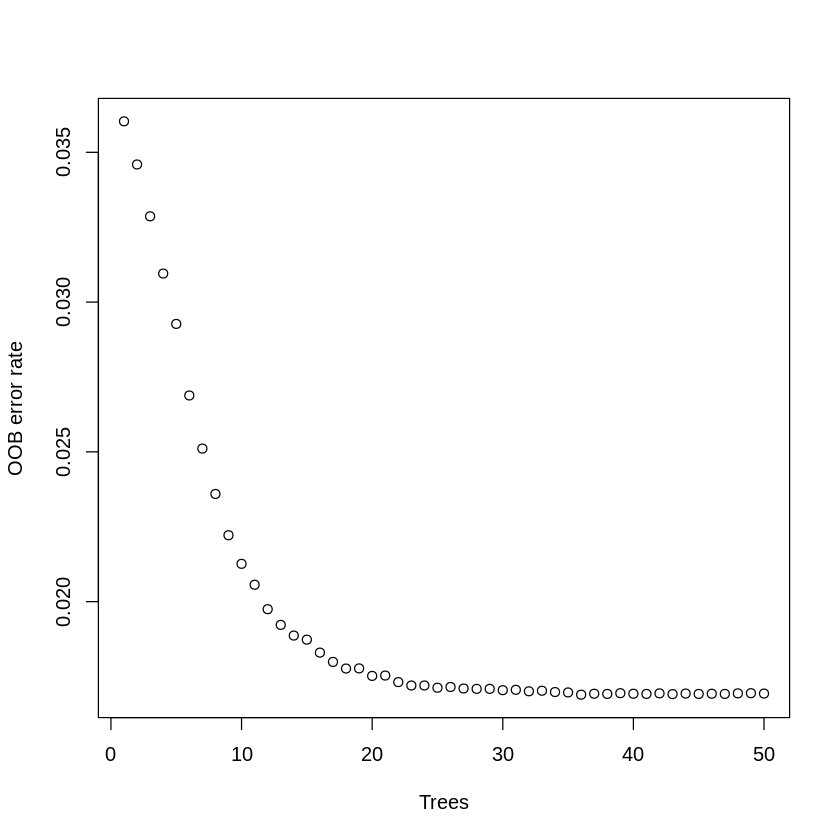

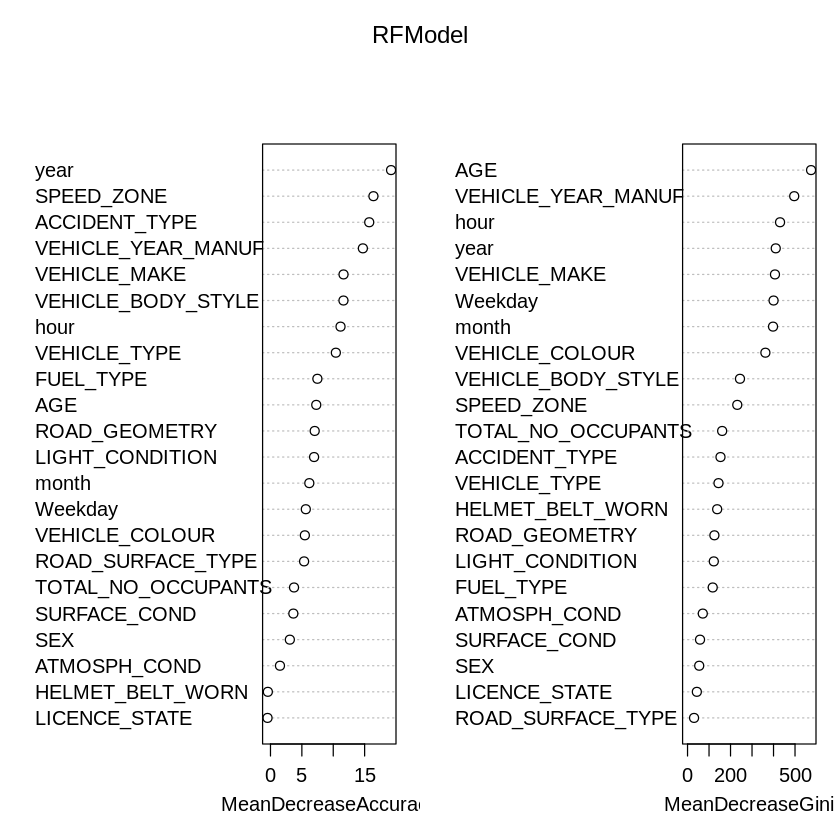

In [ ]:
plot(RFModel$err.rate[,1], xlab = "Trees", ylab = "OOB error rate")
varImpPlot(RFModel)

**Question:** Which variable was most important in the Random Forest? Why might that be?

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.7505

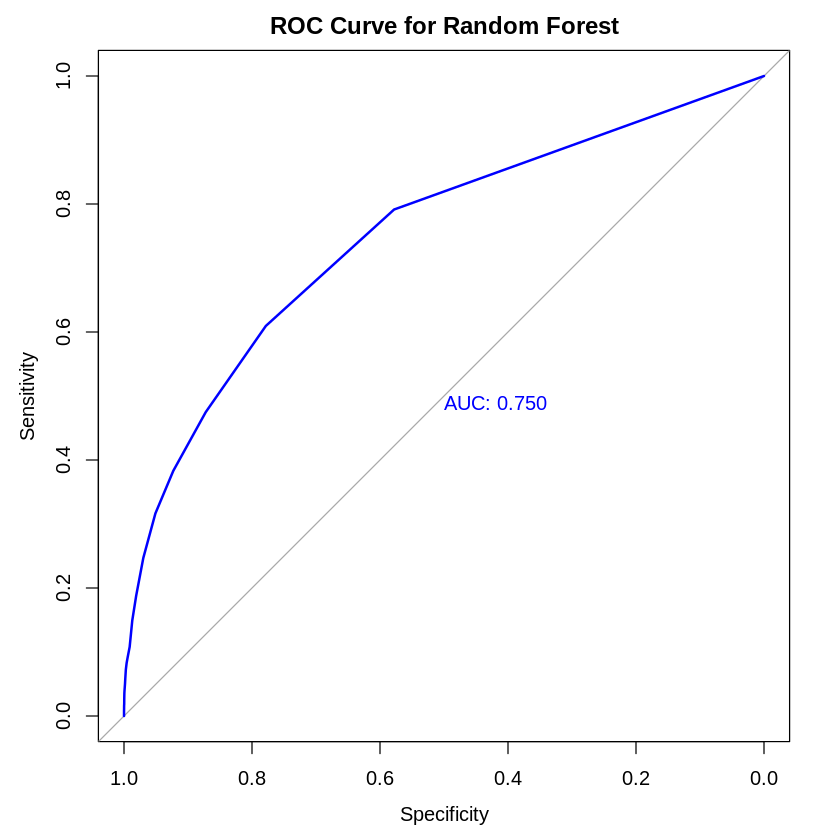

In [ ]:
predTestRF <- RFModel$test$votes[, 2]
ROC_test_RF <- roc(vicDataTest$fatal_cnt, predTestRF)
plot(ROC_test_RF, col = "blue", main = "ROC Curve for Random Forest", print.auc = TRUE)
auc(ROC_test_RF)

## 5. XGBoost: Training with early stopping
We do an 80/20 split on the training data for validation and apply early stopping to prevent overfitting.

In [ ]:
set.seed(23)
train_idx <- sample(1:nrow(vicDataTrain), round(0.8 * nrow(vicDataTrain)))
train_set <- vicDataTrain[train_idx, ]
valid_set <- vicDataTrain[-train_idx, ]

`train_set` is used to fit the model. `valid_set` helps determine the best number of rounds.

In [ ]:
X_train <- model.matrix(fatal_cnt ~ . - 1, data = train_set)
y_train <- as.numeric(train_set$fatal_cnt)
X_valid <- model.matrix(fatal_cnt ~ . - 1, data = valid_set)
y_valid <- as.numeric(valid_set$fatal_cnt)
dtrain <- xgb.DMatrix(data = X_train, label = y_train)
dvalid <- xgb.DMatrix(data = X_valid, label = y_valid)
watchlist <- list(train = dtrain, eval = dvalid)
xgb_model <- xgb.train(data = dtrain, objective = "binary:logistic", eval_metric = "logloss",
                       nrounds = 500, watchlist = watchlist,
                       early_stopping_rounds = 10, verbose = 1)

[1]	train-logloss:0.453476	eval-logloss:0.454749 
Multiple eval metrics are present. Will use eval_logloss for early stopping.
Will train until eval_logloss hasn't improved in 10 rounds.

[2]	train-logloss:0.321832	eval-logloss:0.324141 
[3]	train-logloss:0.239978	eval-logloss:0.243144 
[4]	train-logloss:0.186242	eval-logloss:0.190187 
[5]	train-logloss:0.149883	eval-logloss:0.154624 
[6]	train-logloss:0.124952	eval-logloss:0.130417 
[7]	train-logloss:0.107672	eval-logloss:0.113797 
[8]	train-logloss:0.095646	eval-logloss:0.102535 
[9]	train-logloss:0.087210	eval-logloss:0.094722 
[10]	train-logloss:0.081265	eval-logloss:0.089493 
[11]	train-logloss:0.077183	eval-logloss:0.085865 
[12]	train-logloss:0.074257	eval-logloss:0.083529 
[13]	train-logloss:0.072102	eval-logloss:0.082114 
[14]	train-logloss:0.070468	eval-logloss:0.081088 
[15]	train-logloss:0.069286	eval-logloss:0.080450 
[16]	train-logloss:0.068502	eval-logloss:0.079929 
[17]	train-logloss:0.067693	eval-logloss:0.079652 
[18]

We can now plot the log-loss both in the training set and in the validation set.

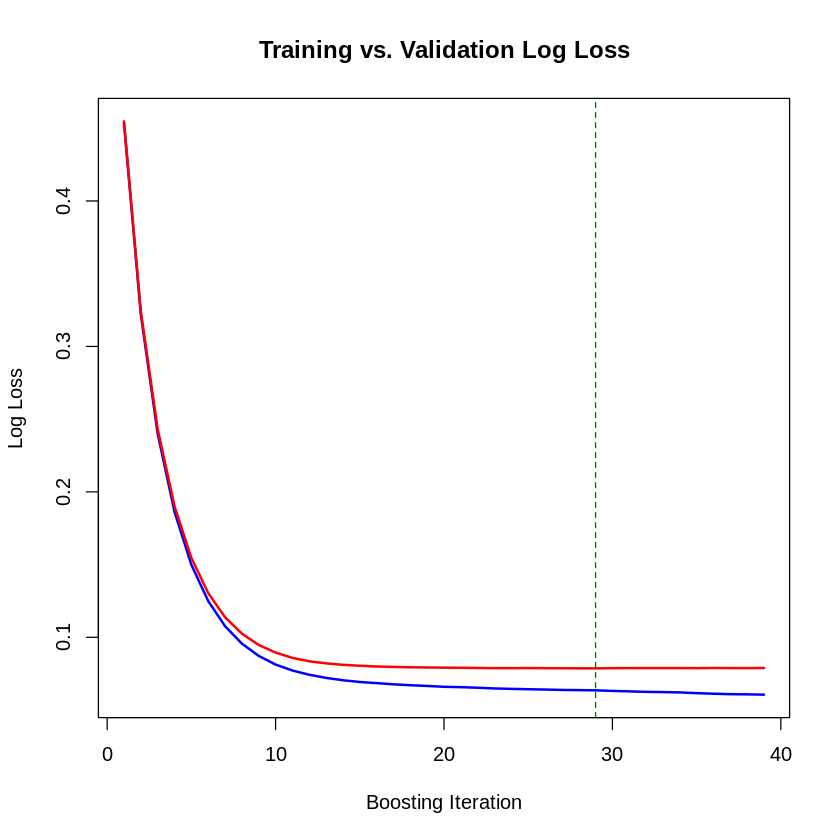

In [ ]:
plot(xgb_model$evaluation_log$iter, xgb_model$evaluation_log$train_logloss,
     type = "l", col = "blue", lwd = 2,
     xlab = "Boosting Iteration", ylab = "Log Loss",
     ylim = range(c(xgb_model$evaluation_log$train_logloss, xgb_model$evaluation_log$eval_logloss)),
     main = "Training vs. Validation Log Loss")
lines(xgb_model$evaluation_log$iter, xgb_model$evaluation_log$eval_logloss, col = "red", lwd = 2)
abline(v = xgb_model$best_iteration, col = "darkgreen", lty = 2)

**Try this:** What happens if you remove early stopping? How does the training vs. validation loss behave?

## 6. Final XGBoost model
We retrain XGBoost on the full training set using the optimal number of iterations.

In [ ]:
X_full <- model.matrix(fatal_cnt ~ . - 1, data = vicDataTrain)
y_full <- as.numeric(vicDataTrain$fatal_cnt)
dtrain_full <- xgb.DMatrix(data = X_full, label = y_full)
final_model <- xgb.train(data = dtrain_full, objective = "binary:logistic",
                         nrounds = xgb_model$best_iteration, eval_metric = "logloss", verbose = 0)

## 7. Evaluate XGBoost on test set
We use the held-out 20% test set for final evaluation.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8045

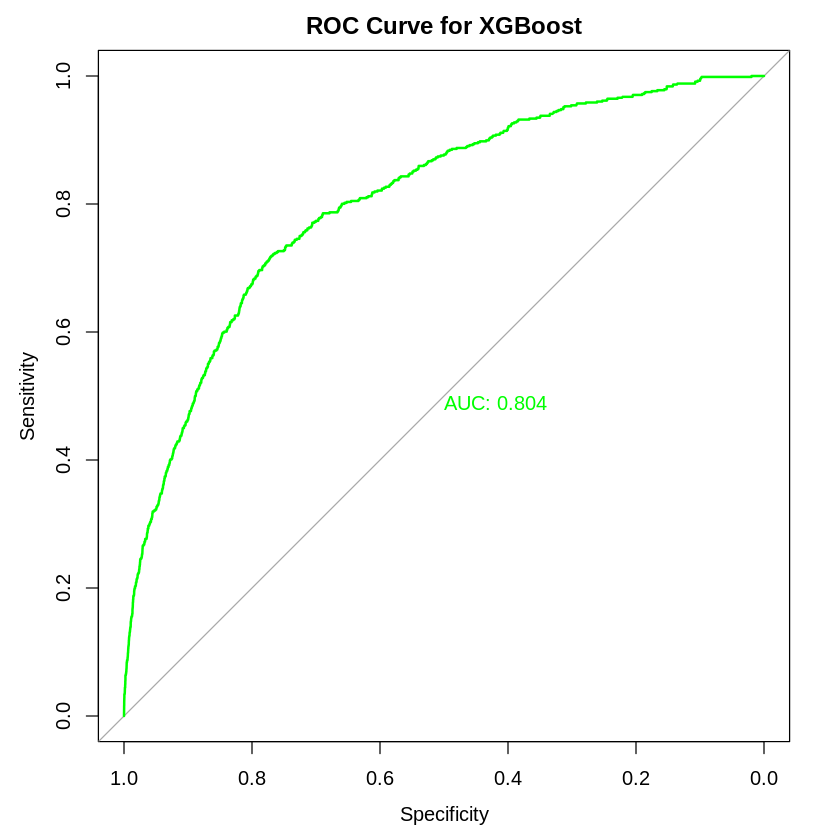

In [ ]:
X_test <- model.matrix(fatal_cnt ~ . - 1, data = vicDataTest)
y_test <- as.numeric(vicDataTest$fatal_cnt)
dtest <- xgb.DMatrix(data = X_test, label = y_test)
predTestxgboost <- predict(final_model, newdata = dtest)
ROC_test_xgb <- roc(vicDataTest$fatal_cnt, predTestxgboost)
plot(ROC_test_xgb, col = "green", main = "ROC Curve for XGBoost", print.auc = TRUE)
ROC_test_xgb$auc

**Challenge:** Compare this AUC with the Random Forest one. Which model generalised better?

## 8. Feature importance (XGBoost)
Check which features were most important across all trees.

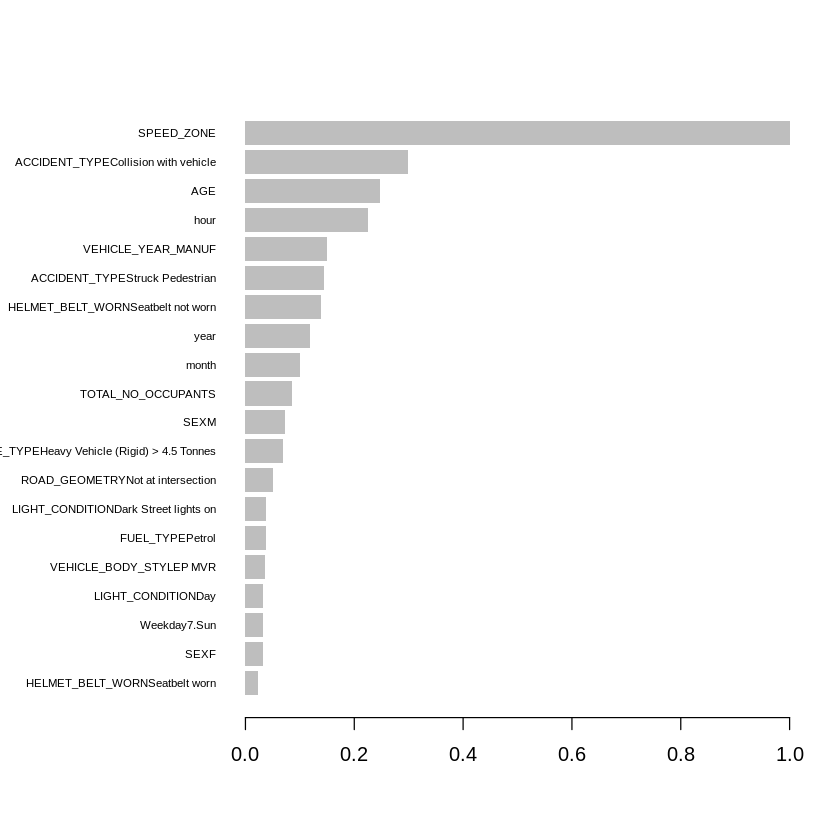

In [ ]:
xgbVarI <- xgb.importance(model = final_model)
xgb.plot.importance(xgbVarI, top_n = 20, rel_to_first = TRUE)

## 9. Partial Dependence Plots (PDP)
Understand the average marginal effect of a feature on predicted probabilities.

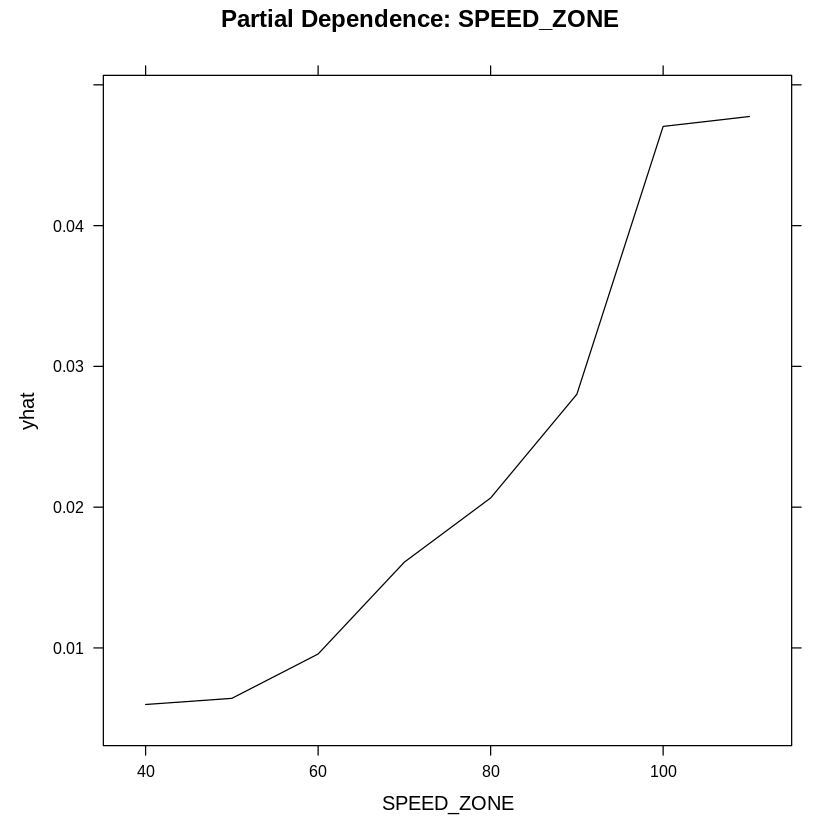

In [ ]:
X_df <- as.data.frame(X_full)
pdp_speed <- partial(object = final_model, pred.var = "SPEED_ZONE", train = X_df,
                     type = "classification", prob = TRUE)
plotPartial(pdp_speed, main = "Partial Dependence: SPEED_ZONE")

**Try this:** Create PDPs for `AGE` or `hour`. Do you notice any nonlinear patterns?

## 10. ICE plots
Display how predictions change for individual cases.

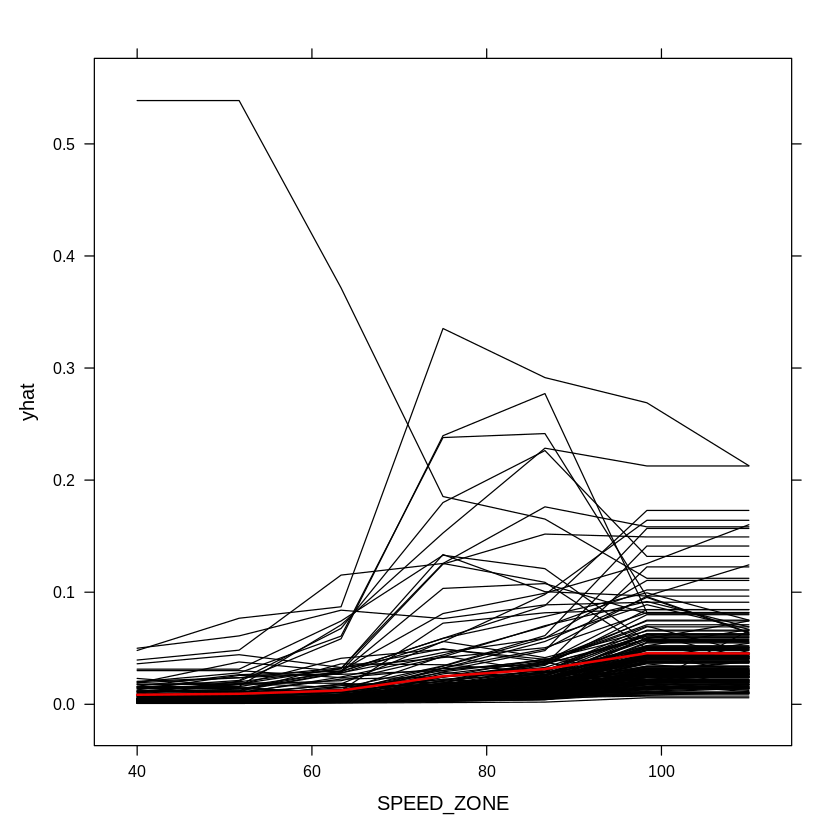

In [ ]:
set.seed(34)
iceID <- sample(1:nrow(X_df), 200)
ice_speed <- partial(object = final_model, pred.var = "SPEED_ZONE",
                     train = X_df[iceID, ], type = "classification", prob = TRUE, ice = TRUE)
plotPartial(ice_speed)

ICE plots give instance-level insight — unlike PDPs which average.

## 11. SHAP values
Explain predictions by attributing output to each feature.

In [ ]:
shap_result <- shap.values(xgb_model = final_model, X_train = X_full)
shap_result_long <- shap.prep(shap_contrib = shap_result$shap_score,
                              X_train = X_full, top_n = 20)

In [ ]:
predTrainxgboost <- predict(final_model, newdata = dtrain_full)
maxID <- which.max(predTrainxgboost)
minID <- which.min(predTrainxgboost)

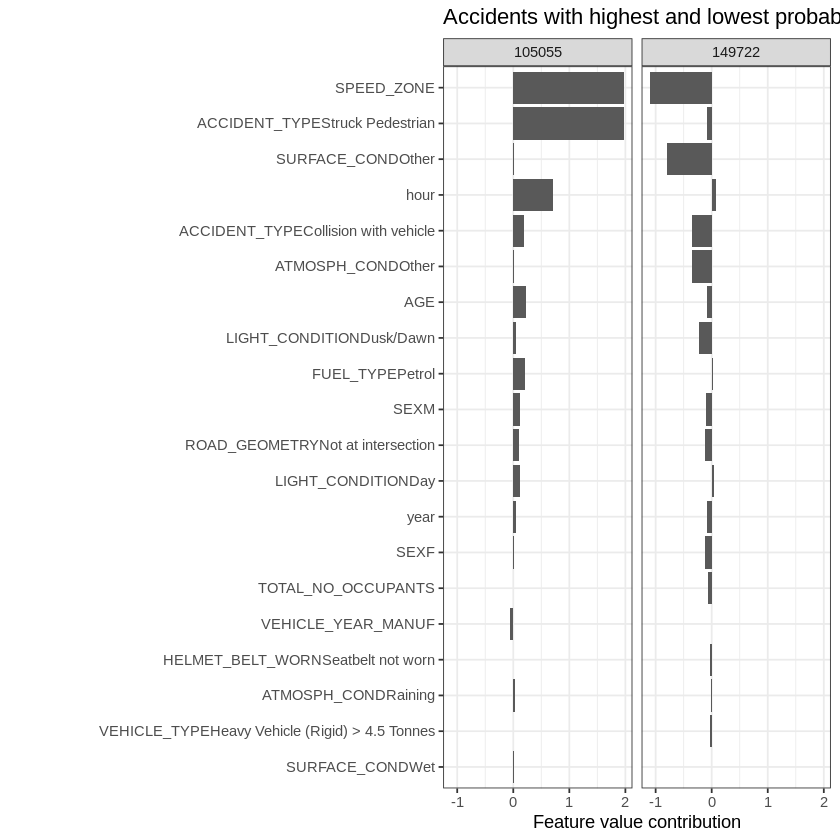

In [ ]:
shap_data_plot <- shap_result_long %>% filter(ID %in% c(minID, maxID))
ggplot(shap_data_plot) +
  geom_bar(aes(x = reorder(variable, abs(value)), y = value), stat = "identity") +
  labs(x = "", y = "Feature value contribution",
       title = "Accidents with highest and lowest probability") +
  coord_flip() + facet_wrap(~ID) + theme_bw()

In [ ]:
outTable <- t(vicDataTrain[c(minID, maxID), ] %>% select(SPEED_ZONE, ACCIDENT_TYPE, hour, AGE, SEX))
outDF <- as.data.frame(outTable) %>% rownames_to_column()
colnames(outDF) <- c("Variable", "Min", "Max")
outDF

Variable,Min,Max
<chr>,<chr>,<chr>
SPEED_ZONE,50,110
ACCIDENT_TYPE,Collision with vehicle,Struck Pedestrian
hour,6,2
AGE,51,36
SEX,F,M


**Question:** For the highest-risk prediction, which features pushed the probability up most?

##  Student prompts (summary)
- Change the number of trees or learning rate in XGBoost. What happens?
- Try PDP and ICE for other variables. Do individual patterns differ from average ones?
- Interpret another observation using SHAP. What surprised you?
- Compare RF vs XGBoost in accuracy and interpretability. Which would you prefer for deployment?